In [1]:
import os
import numpy as np
import pandas as pd
from collections import defaultdict
import re
import io

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


# --- Configuration ---
TARGET_SAMPLING_RATE_HZ = 20.0  # Target sampling rate in Hz
WINDOW_SECONDS = 6
WINDOW_SIZE = int(TARGET_SAMPLING_RATE_HZ * WINDOW_SECONDS) # x samples for y seconds at 50Hz

STEP_SECONDS = 2 # x秒步长
STEP = int(TARGET_SAMPLING_RATE_HZ * STEP_SECONDS)          # 50*x samples for x second step at 50Hz

## 处理原始数据

In [2]:
DATASEQ_PATH = f'SensorDataSequences_UMAFall_IDs1234and0_20Hz_{WINDOW_SECONDS}s.npy'
LABELSEQ_PATH = f'SensorLabelSequences_UMAFall_IDs1234and0_20Hz_{WINDOW_SECONDS}s.npy'

if os.path.exists(DATASEQ_PATH) and os.path.exists(LABELSEQ_PATH):
    print("Found existing npy files. Loading...")
    SensorDataSequences = np.load(DATASEQ_PATH)
    print(f"Loaded dataset shape: X={SensorDataSequences.shape}")
    SensorLabelSequences = np.load(LABELSEQ_PATH)
    print(f"Loaded dataset shape: y={SensorLabelSequences.shape}")
else:
    print("No existing npy files found. Please run data_extract.py first to generate the required data files.")

Found existing npy files. Loading...
Loaded dataset shape: X=(2531, 120, 48)
Loaded dataset shape: y=(2531,)


## 自回归模型定义

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers, dropout):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)

    def forward(self, x):
        # x shape: (batch_size, seq_len, input_dim)
        # outputs shape: (batch_size, seq_len, hidden_dim)
        # hidden, cell shapes: (n_layers, batch_size, hidden_dim)
        outputs, (hidden, cell) = self.lstm(x)
        # 将最后一个时间步的隐藏状态和细胞状态作为上下文向量
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, n_layers, dropout):
        super(Decoder, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.lstm = nn.LSTM(output_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, hidden, cell):
        # x shape: (batch_size, 1, output_dim) - 初始输入是序列的最后一个点
        # hidden, cell shapes: (n_layers, batch_size, hidden_dim)
        output, (hidden, cell) = self.lstm(x, (hidden, cell))
        # output shape: (batch_size, 1, hidden_dim)
        prediction = self.fc(output)
        # prediction shape: (batch_size, 1, output_dim)
        return prediction, hidden, cell

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, source, target, teacher_forcing_ratio=0.5):
        # source shape: (batch_size, input_len, input_dim)
        # target shape: (batch_size, target_len, output_dim)
        batch_size = source.shape[0]
        target_len = target.shape[1]
        target_dim = self.decoder.output_dim

        # 存储解码器输出的张量
        outputs = torch.zeros(batch_size, target_len, target_dim).to(self.device)

        # 编码器传递上下文向量
        hidden, cell = self.encoder(source)

        # 解码器的第一个输入是源序列的最后一个时间点
        # 这里为了简化，使用一个全零的输入开始
        decoder_input = torch.zeros(batch_size, 1, target_dim).to(self.device)

        for t in range(target_len):
            output, hidden, cell = self.decoder(decoder_input, hidden, cell)
            outputs[:, t:t+1, :] = output

            # 决定是否使用 "Teacher Forcing"
            teacher_force = np.random.random() < teacher_forcing_ratio
            # 如果使用，下一个输入是真实的标签；否则，使用模型自己的预测
            decoder_input = target[:, t:t+1, :] if teacher_force else output

        return outputs

## 数据集类定义

In [4]:
# --- 基本设置 ---
# 检查是否有可用的GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 为了结果可复现，设置随机种子
torch.manual_seed(42)
np.random.seed(42)


class TimeSeriesDataset(Dataset):
    def __init__(self, data, input_len, target_len):
        self.data = data
        self.input_len = input_len
        self.target_len = target_len
        # 总序列长度必须等于 input_len + target_len
        assert data.shape[1] == input_len + target_len, "Data sequence length does not match input_len + target_len"

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sequence = self.data[idx]
        x = sequence[:self.input_len]
        y = sequence[self.input_len:]
        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

# --- 定义序列长度 ---
# 使用前200个点来预测后100个点
INPUT_SEQ_LEN = 80
TARGET_SEQ_LEN = 40
TOTAL_SEQ_LEN = INPUT_SEQ_LEN + TARGET_SEQ_LEN

Using device: cuda


## 训练函数定义

In [5]:
mae_criterion = nn.L1Loss() # MAE Loss

def train_model(model, train_loader, val_loader, optimizer, criterion, epochs):
    """
    模型训练主函数
    """
    best_val_loss = float('inf')

    train_loss_history = []
    val_loss_history = []
    val_mae_history = []
    val_rmse_history = []
    val_r2_history = []

    for epoch in range(epochs):
        
        # --- 训练模式 ---
        model.train()
        train_loss = 0
        for i, (inputs, targets) in enumerate(train_loader):
            inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()

            outputs = model(inputs, targets)

            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # --- 评估模式 ---
        model.eval()
        val_loss = 0
        val_mae = 0
        val_r2 = 0  # 添加R2累加器
        
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                outputs = model(inputs, targets, teacher_forcing_ratio=0) 
                
                loss = criterion(outputs, targets) # MSE Loss
                mae = mae_criterion(outputs, targets) # MAE Loss
                
                val_loss += loss.item()
                val_mae += mae.item() # 累加MAE
                
                # --- 计算 R2 ---
                # r2_score 需要 numpy 数组，并且是 (n_samples, n_outputs) 的2D形状
                targets_np = targets.cpu().numpy()
                outputs_np = outputs.cpu().numpy()
                
                # 将 (batch, seq_len, features) 展平为 (batch*seq_len, features)
                targets_np_flat = targets_np.reshape(-1, targets_np.shape[-1])
                outputs_np_flat = outputs_np.reshape(-1, outputs_np.shape[-1])
                
                # 计算R2分数并累加（注意：逐批平均R2并不完全精确，但作为趋势监控是可行的）
                val_r2 += r2_score(targets_np_flat, outputs_np_flat, multioutput='variance_weighted')

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader) # 这是平均 MSE
        avg_val_mae = val_mae / len(val_loader) # 这是平均 MAE
        avg_val_rmse = np.sqrt(avg_val_loss)     # 计算 RMSE (RMSE = sqrt(MSE))
        avg_val_r2 = val_r2 / len(val_loader)    # 计算平均 R2

        train_loss_history.append(avg_train_loss)
        val_loss_history.append(avg_val_loss)
        val_mae_history.append(avg_val_mae)
        val_rmse_history.append(avg_val_rmse)
        val_r2_history.append(avg_val_r2)

        print(f'Epoch: {epoch+1:02}')
        print(f'Train Loss: {avg_train_loss:.4f},  Val. Loss: {avg_val_loss:.4f},  Val. MAE: {avg_val_mae:.4f},  Val. RMSE: {avg_val_rmse:.4f},  Val. R2: {avg_val_r2:.4f}')

        # 保存表现最好的模型
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), 'autoregression_feature_extractor_model.pt')
            print(f'\tBest model saved with validation loss: {best_val_loss:.4f}')

    return train_loss_history, val_loss_history, val_mae_history, val_rmse_history, val_r2_history

## 训练启动代码

In [6]:
# 1. 设置超参数
INPUT_DIM = 48      # 每个时间点的特征数
OUTPUT_DIM = 48     # 输出维度和输入维度相同
HIDDEN_DIM = 64     # 隐藏层维度，这个值决定了特征向量的维度，可以调整
N_LAYERS = 2        # LSTM层数
DROPOUT = 0.1
BATCH_SIZE = 128
EPOCHS = 100
LEARNING_RATE = 0.001

# 1. 划分数据集
train_data, val_data = train_test_split(SensorDataSequences, test_size=0.2, random_state=42)

# 2. 创建并拟合Scaler
# 需要将数据 reshape 成 2D 来进行拟合
# (num_samples * seq_len, num_features)
num_train_samples, seq_len, num_features = train_data.shape
num_val_samples = val_data.shape[0]

# 只用训练数据来拟合Scaler
scaler = StandardScaler()
scaler.fit(train_data.reshape(-1, num_features))

# 3. 标准化训练集和验证集
train_data_scaled = scaler.transform(train_data.reshape(-1, num_features)).reshape(num_train_samples, seq_len, num_features)
val_data_scaled = scaler.transform(val_data.reshape(-1, num_features)).reshape(num_val_samples, seq_len, num_features)

print("Data successfully standardized.")
print("Original train data mean (first feature):", np.mean(train_data[:,:,0]))
print("Scaled train data mean (first feature):", np.mean(train_data_scaled[:,:,0])) # 应该接近 0
print("Scaled train data std (first feature):", np.std(train_data_scaled[:,:,0]))

# 保存Scaler以便后续使用
scaler_filename = "autoregression_timeseries_data_scaler.save"
joblib.dump(scaler, scaler_filename)
print(f"Scaler saved to {scaler_filename}")
      
    
# 3. 创建Dataset和DataLoader
train_dataset = TimeSeriesDataset(train_data_scaled, INPUT_SEQ_LEN, TARGET_SEQ_LEN)
val_dataset = TimeSeriesDataset(val_data_scaled, INPUT_SEQ_LEN, TARGET_SEQ_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# 4. 实例化模型、优化器和损失函数
encoder = Encoder(INPUT_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
decoder = Decoder(OUTPUT_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
model = Seq2Seq(encoder, decoder, device).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss() # 均方误差损失，适合回归预测任务

train_loss_history, val_loss_history, val_mae_history, val_rmse_history, val_r2_history = [], [], [], [], []

# 5. 开始训练
print("\nStarting model training...")
train_loss_history, val_loss_history, val_mae_history, val_rmse_history, val_r2_history = train_model(model, train_loader, val_loader, optimizer, criterion, EPOCHS)
print("Training finished.")

Data successfully standardized.
Original train data mean (first feature): 0.648320831831579
Scaled train data mean (first feature): 7.114788921972018e-17
Scaled train data std (first feature): 1.0000000000000246
Scaler saved to autoregression_timeseries_data_scaler.save

Starting model training...
Epoch: 01
Train Loss: 0.9299,  Val. Loss: 0.9148,  Val. MAE: 0.6214,  Val. RMSE: 0.9565,  Val. R2: -0.0018
	Best model saved with validation loss: 0.9148
Epoch: 02
Train Loss: 0.8412,  Val. Loss: 0.7936,  Val. MAE: 0.5587,  Val. RMSE: 0.8908,  Val. R2: 0.1311
	Best model saved with validation loss: 0.7936
Epoch: 03
Train Loss: 0.7453,  Val. Loss: 0.7356,  Val. MAE: 0.5211,  Val. RMSE: 0.8577,  Val. R2: 0.1946
	Best model saved with validation loss: 0.7356
Epoch: 04
Train Loss: 0.6937,  Val. Loss: 0.7026,  Val. MAE: 0.5061,  Val. RMSE: 0.8382,  Val. R2: 0.2307
	Best model saved with validation loss: 0.7026
Epoch: 05
Train Loss: 0.6508,  Val. Loss: 0.6774,  Val. MAE: 0.4925,  Val. RMSE: 0.8230,

## 绘制训练指标图

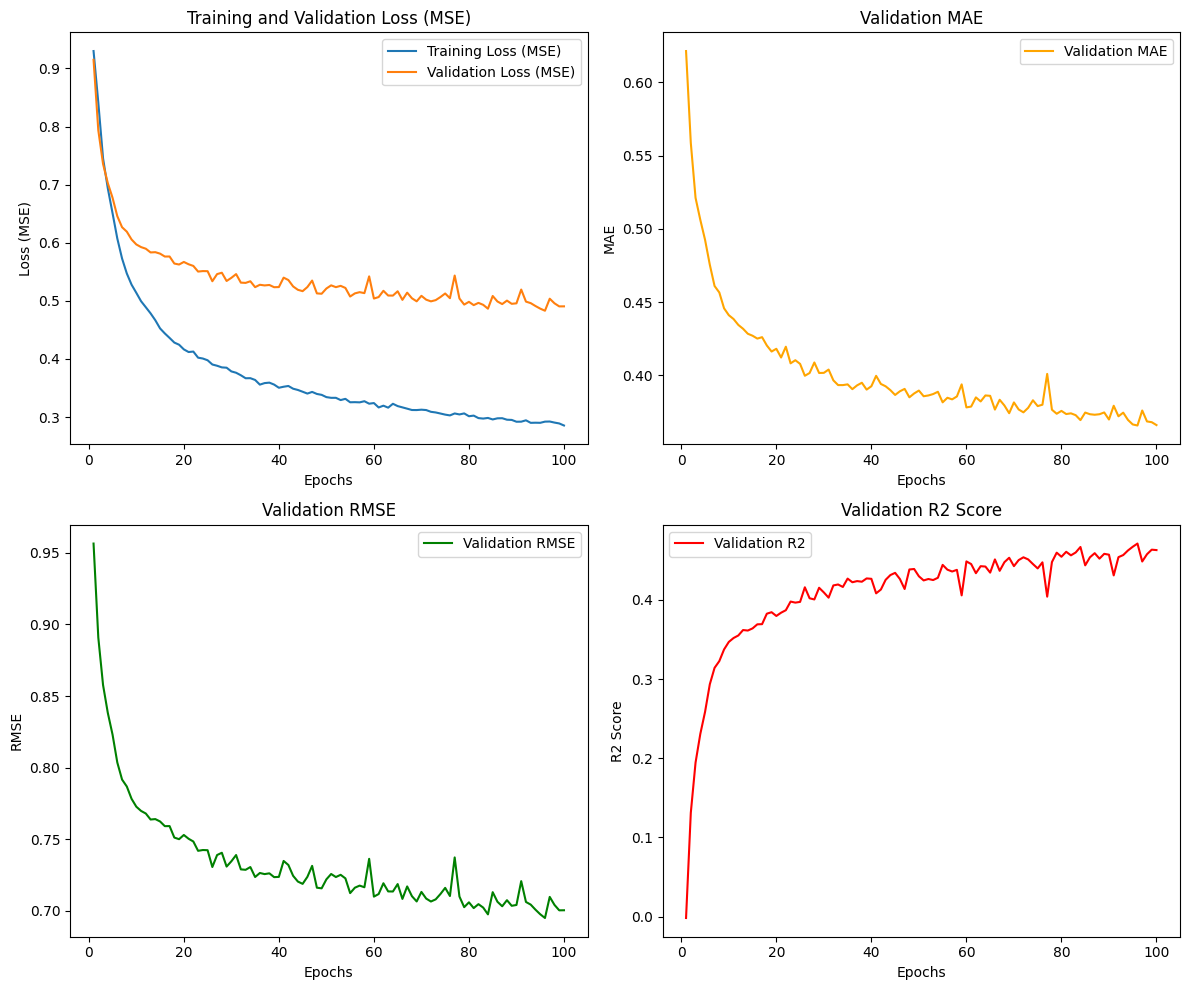

In [7]:
import matplotlib.pyplot as plt

# 6. 绘制训练指标图
epochs = range(1, len(train_loss_history) + 1)

plt.figure(figsize=(12, 10)) # <-- 调整画布大小

# 绘制损失曲线 (MSE)
plt.subplot(2, 2, 1)
plt.plot(epochs, train_loss_history, label='Training Loss (MSE)')
plt.plot(epochs, val_loss_history, label='Validation Loss (MSE)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss (MSE)')
plt.legend()

# 绘制MAE曲线
plt.subplot(2, 2, 2)
plt.plot(epochs, val_mae_history, label='Validation MAE', color='orange')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Validation MAE')
plt.legend()

# --- 添加新图 ---

# 绘制RMSE曲线
plt.subplot(2, 2, 3)
plt.plot(epochs, val_rmse_history, label='Validation RMSE', color='green')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.title('Validation RMSE')
plt.legend()

# 绘制R2曲线
plt.subplot(2, 2, 4)
plt.plot(epochs, val_r2_history, label='Validation R2', color='red')
plt.xlabel('Epochs')
plt.ylabel('R2 Score')
plt.title('Validation R2 Score')
plt.legend()
# -----------------

plt.tight_layout()
plt.show()